<a href="https://colab.research.google.com/github/Ha-Master7/DL_assignment1/blob/task1/01_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'dl/assignments/assignment1/'
FOLDERNAME = 'dl/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/dl/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/dl/assignments/assignment1/dl/datasets
/content/drive/My Drive/dl/assignments/assignment1


# Softmax Classifier exercise


In this exercise you will:
    
- implement a fully-vectorized **loss function** for the Softmax classifier.
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from dl.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'dl/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


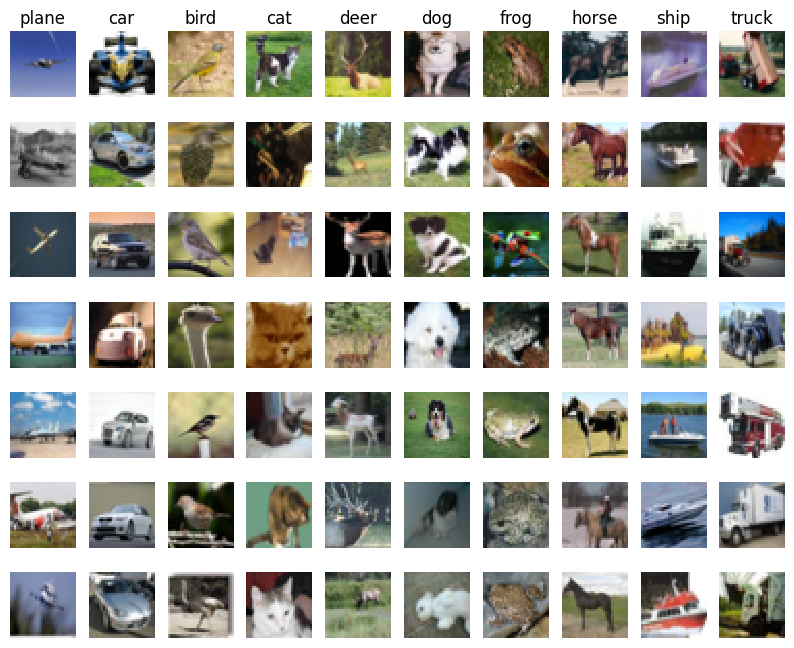

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


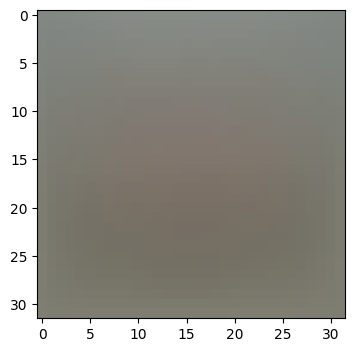

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `dl/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from dl.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))
print(grad.shape)

loss: 2.361754
loss: 2.361754
sanity check: 2.302585
(3073, 10)


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ We expect the loss to be close to -log(0.1)because the weights are initialized with very small random values. This makes all the class scores almost the same, and since the softmax outputs probabilities that must sum to 1, each class gets roughly an equal share. With 10 classes, that means each one is about 1/10 = 0.1 , The loss for each sample is -log(score of the correct class), so it becomes apx. log(0.1). This is why the average loss at the start is close to that value—the model is basically guessing equally among all classes.

Also, running the experiment many times shows that the true-class probability usually falls around P ≈ 0.1 (typically between [89/1000 ,104/1000]), which is very close to 100/1000 = 0.1 and matches our intuition for a nearly uniform distribution


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from dl.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 3.374718 analytic: 3.374718, relative error: 6.853180e-09
numerical: -0.133647 analytic: -0.133647, relative error: 2.806071e-07
numerical: 0.322214 analytic: 0.322214, relative error: 4.078942e-08
numerical: -0.927757 analytic: -0.927757, relative error: 4.342776e-09
numerical: -2.158621 analytic: -2.158622, relative error: 4.539471e-08
numerical: -4.926574 analytic: -4.926574, relative error: 1.086047e-08
numerical: -1.087933 analytic: -1.087933, relative error: 4.160728e-08
numerical: 3.167069 analytic: 3.167069, relative error: 2.100865e-08
numerical: -1.861696 analytic: -1.861696, relative error: 7.165298e-09
numerical: 0.333993 analytic: 0.333993, relative error: 8.930398e-08
numerical: 1.668656 analytic: 1.668656, relative error: 1.190839e-08
numerical: -0.895162 analytic: -0.895162, relative error: 4.383323e-09
numerical: 1.381510 analytic: 1.381510, relative error: 1.516064e-08
numerical: -0.969236 analytic: -0.969236, relative error: 1.854407e-08
numerical: 2.85734

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly.

What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin.

*Hint: the SVM loss function is not strictly speaking differentiable.*


$\color{blue}{\textit Your Answer:}$

**A.** The discrepancy happens because the SVM hinge loss is not differentiable at the point where $s_j - s_{y_i} + \Delta = 0.
$ Gradient check uses tiny finite differences, so if we are very close to this kink, the numerical and analytic gradients may not match.

**B.** It is not a concern because backprop never relies on finite differences. The model almost never lands exactly on the nondifferentiable point, so training is unaffected.

**C.** A simple 1-D failure case is when $
s_j - s_{y_i} + \Delta = 0$

The hinge switches from 0 to positive there, so the slope jumps and finite differences read different values on each side.

**D.** Changing Δ only moves where the kink is located it does not make the model hit it more often. The nondifferentiable point is still just a single value, so mismatches remain rare.

In [ ]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.361754e+00 computed in 0.074206s
Vectorized loss: 2.361754e+00 computed in 0.012433s
difference: 0.000000


In [ ]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.109675s
Vectorized loss and gradient: computed in 0.009619s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `dl/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from dl.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.310757
iteration 100 / 1500: loss 288.007781
iteration 200 / 1500: loss 106.742597
iteration 300 / 1500: loss 40.311756
iteration 400 / 1500: loss 16.057462
iteration 500 / 1500: loss 7.198559
iteration 600 / 1500: loss 3.909639
iteration 700 / 1500: loss 2.769399
iteration 800 / 1500: loss 2.342930
iteration 900 / 1500: loss 2.160078
iteration 1000 / 1500: loss 2.110094
iteration 1100 / 1500: loss 2.176059
iteration 1200 / 1500: loss 2.095568
iteration 1300 / 1500: loss 2.123266
iteration 1400 / 1500: loss 2.034464
That took 7.086493s


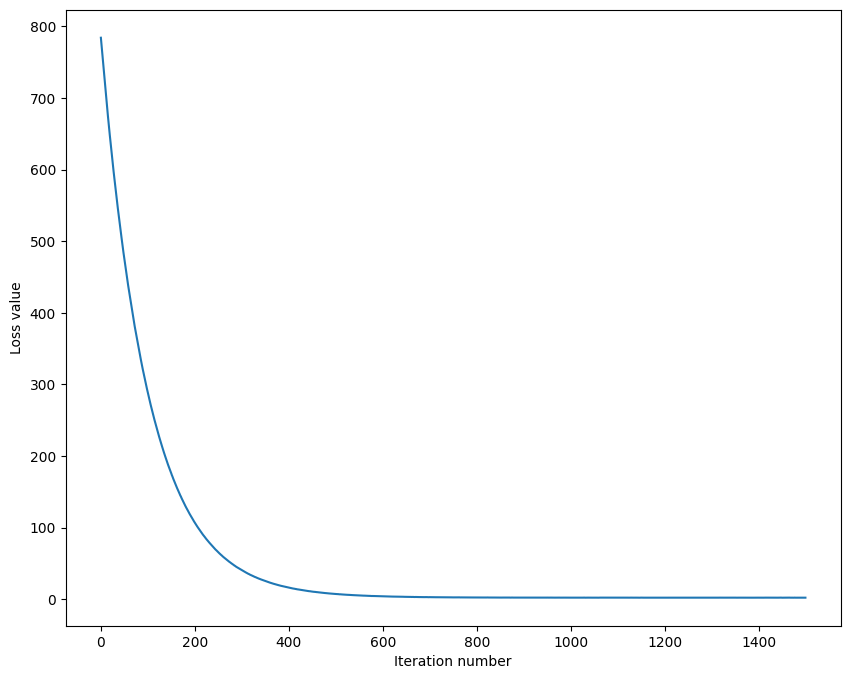

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.326286
validation accuracy: 0.354000


In [ ]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.
# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [2e-7, 2.5e-7, 3e-7]
regularization_strengths = [0.75e4, 0.8e4, 0.85e4]

# Provided as a reference. You may or may not want to change these hyperparameters
#learning_rates = [1e-7, 1e-6]
#regularization_strengths = [2.5e4, 1e4]
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax on the         #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this.   #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Try all combinations of learning rates and regularization strengths
for lr in learning_rates:
    for reg in regularization_strengths:
        # Create a new Softmax classifier for each (lr, reg)
        softmax = Softmax()

        # Train the classifier with these hyperparameters
        loss_history = softmax.train(
            X_train,
            y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=2000,    # you can start with e.g. 200 while debugging
            batch_size=300,
            verbose=False,
        )

        # Predict on training and validation sets
        y_train_pred = softmax.predict(X_train)
        y_val_pred   = softmax.predict(X_val)

        # Compute accuracies
        train_acc = np.mean(y_train_pred == y_train)
        val_acc   = np.mean(y_val_pred == y_val)

        # Store in results dict
        results[(lr, reg)] = (train_acc, val_acc)

        # Keep track of the best model (highest val accuracy)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train; once  #
# you are confident that your validation code works, you should rerun the      #
# code with a larger value for num_iters.                                      #
################################################################################




# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.000000e-07 reg 7.500000e+03 train accuracy: 0.363490 val accuracy: 0.381000
lr 2.000000e-07 reg 8.000000e+03 train accuracy: 0.365184 val accuracy: 0.376000
lr 2.000000e-07 reg 8.500000e+03 train accuracy: 0.360020 val accuracy: 0.370000
lr 2.500000e-07 reg 7.500000e+03 train accuracy: 0.363612 val accuracy: 0.384000
lr 2.500000e-07 reg 8.000000e+03 train accuracy: 0.363714 val accuracy: 0.384000
lr 2.500000e-07 reg 8.500000e+03 train accuracy: 0.365469 val accuracy: 0.381000
lr 3.000000e-07 reg 7.500000e+03 train accuracy: 0.364061 val accuracy: 0.382000
lr 3.000000e-07 reg 8.000000e+03 train accuracy: 0.361714 val accuracy: 0.383000
lr 3.000000e-07 reg 8.500000e+03 train accuracy: 0.363082 val accuracy: 0.388000
best validation accuracy achieved during cross-validation: 0.388000


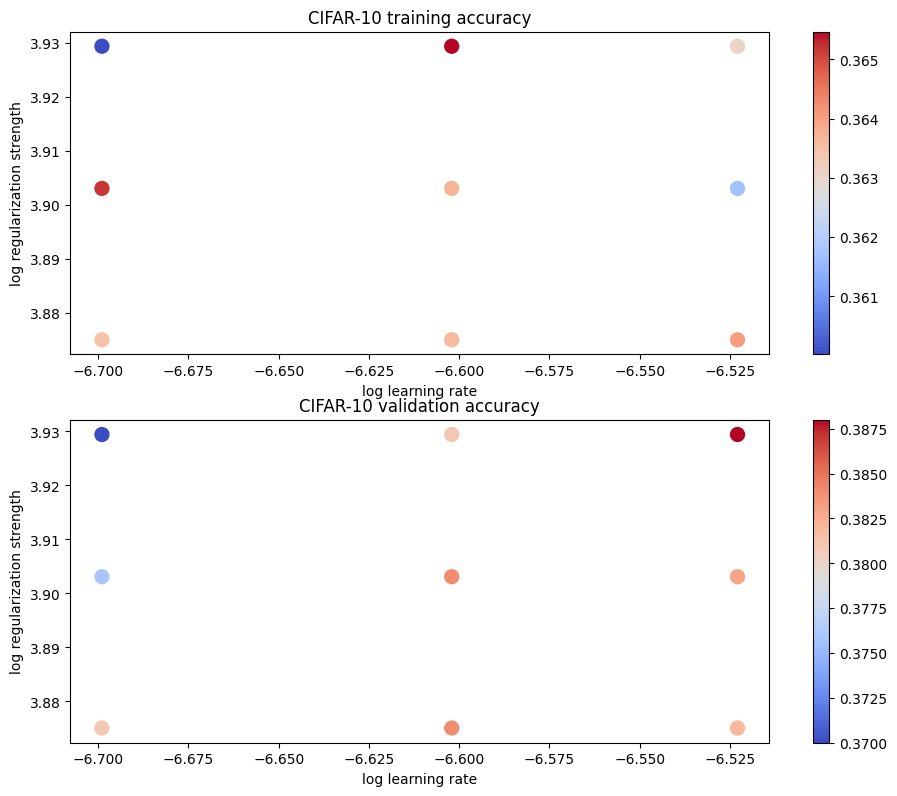

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.367000


In [ ]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


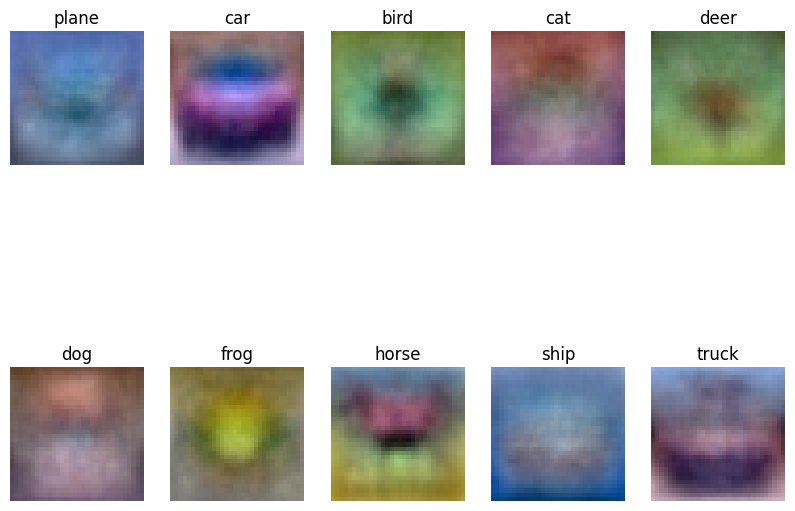

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$

The visualized Softmax weights appear as blurry, smoothed “average images” for each class. Since a linear Softmax classifier can only learn one weight vector per class, it captures only broad color and intensity patterns rather than detailed shapes. As a result, each weight map resembles a fuzzy template showing which pixel regions tend to be important for predicting that class (e.g., ships appear bluish, frogs greenish).


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

$\color{blue}{\textit Your Answer:}$
True

$\color{blue}{\textit Your Explanation:}$ The SVM hinge loss becomes zero for datapoints that satisfy the margin (i.e., all $s_j - s_y + Δ < 0$). Adding such a datapoint does not change the total SVM loss. However, the Softmax loss never becomes exactly zero, since it depends on the negative log of the predicted probability for the correct class. Even a perfectly classified example with high confidence still has a positive Softmax loss. Therefore, adding the datapoint will change the Softmax loss but leave the SVM loss unchanged.

